<h1 align="center">Check Questions</h1> 

**Вопрос 1**: Чем нейросети отличаются от линейных моделей, а чем похожи? 

Нейросети и линейные модели похожи тем, что в нейросетях есть линейные слои: в обоих случаях вычисляется какая-то линейная функция. Отличие заключается в том, что в нейросетях так же присутствуют нелинейные слои (по-другому они называются функциями активации; например, ReLU, LeakyReLU). Без этих нелинейных слоев нейросеть была бы линейной моделью (так как композиция линейных моделей есть линейная модель).

**Вопрос 2**: В чем недостатки полносвзяных нейронных сетей, какая мотивация к использованию свёрточных?

Во-первых, полносвязные нейронные сети подвержены переобучению. Во-вторых, они рассматривают признаки, которые являются непосредственно входными данными, а они могут быть бесполезными. Например, при классификации изображений редко какую-то полезную информацию можно вынести из определенного пикселя изображения. Сверточные нейронные сети призваны избавить нас от этих недостатков - с помощью них можно выделять меньшее число призаков, и в то же время "полезность" которых будет намного выше.

**Вопрос 3**: Какие слои используются в современных нейронных сетях? Опишите как работает каждый слой и свою интуицию зачем он нужен.

- Convolution Layer
  * Интуиция: Нужен, чтобы учитывать зависимости между признаками
  * Принцип работы: По таблице скользит фильтр и создает новую таблицу
- Activation Layer
  * Интуиция: Надо сделать что-то особое, чтобы это не было линейной моделью
  * Принцип работы: Добавляем нелинейности (см. ReLU, LeakyReLU)
- Pooling Layer
  * Интуиция: Нужен, чтобы уменьшить размерность
  * Принцип работы: Возьмем подтаблицу и заменим числом с помощью какого-то алгоритма (выберем среднее / максимум)
- Dropout Layer
  * Интуиция: Полносвязные слои --- длительные вычисления
  * Принцип работы: Обнуляет некоторые нейроны
- Dence Layer
  * Интуиция: Базовый слой, на котором все держится
  * Принцип работы: Вычисляем что-то из разряда Wx + b
    
    
**Вопрос 4**: Может ли нейросеть решать задачу регрессии, какой компонент для этого нужно заменить в нейросети из лекции 1?

Этого можно добиться, если сделать следующее:
* Убрать нелинейные слои;
* Убрать softmax слой;
* В качестве функции потерь использовать что-то классическое для задачи регрессии, например, MSE.


**Вопрос 5**: Почему обычные методы оптимизации плохо работают с нейросетями? А какие работают хорошо? Почему они работают хорошо?

Часто при работе с нейросетями мы имеем дело с большими датасетами, большим количеством признаков. Обычные методы тут уже не подойдут, потому что они используют матричное умножение полных матриц (то есть даже не sparse), приходится считать различные Гессианы и пр. Поэтому были придуманы стохастические методы: SGD, Adam и др. Во-первых, они работают быстрее, помещаются в ОП, а во-вторых, легче выходят из седловых точек.

**Вопрос 6**: Для чего нужен backprop, чем это лучше/хуже чем считать градиенты без него? Почему backprop эффективно считается на GPU?

Backprop - способ быстро и точно вычислить градиенты. Он эффективно считается на GPU, потому что GPU может на каждом слое делать вычисления для большого числа нейронов - это может дать сильное ускорение (нейросеть должна быть большой). Возможный минус перед численным вычислением градиента - мы явно задаем функцию и пишем код для ее градиента. В случае с численным вычислением градиента мы можем написать что-то типа дженерика и использовать произвольные нелинейности (теоретически).

**Вопрос 7**: Почему для нейросетей не используют кросс валидацию, что вместо неё? Можно ли ее использовать?

Кросс валидация - это метод борьбы с переобучением, состоящий из нескольких раундов обучения, валидации и тестирования. Он не используется с нейронными сетями, потому что нейронные сети долго обучаются - проведение нескольких раундов займет много времени. Для борьбы с переобучением у нейросетей есть особый слой - Dropout Layer. На этом слое обнуляются некоторые нейроны, что предотвращает переобучение.

**Вопрос 8**: Небольшой quiz который поможет разобраться со свертками https://www.youtube.com/watch?v=DDRa5ASNdq4 

<img src="img/conv.png" width="600">

| Padding | Stride | Width | Height | Depth |
|---------|--------|-------|--------|-------|
| Same    | 1      | 28    | 28     | 8     |
| Valid   | 1      | 26    | 26     | 8     |
| Valid   | 2      | 13    | 13     | 8     |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from IPython import display

%matplotlib inline

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run hw6_Modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

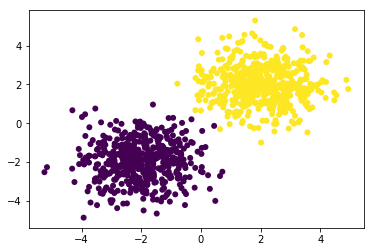

In [53]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [54]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [55]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [56]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

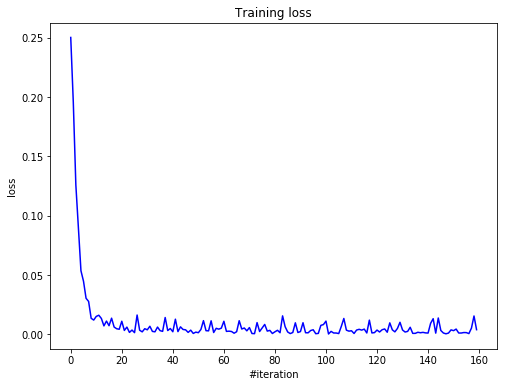

Current loss: 0.004056


In [57]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [10]:
mnist = fetch_mldata('MNIST original')

data = mnist.data
target = mnist.target

data = data / 255.

One-hot encode the labels first.

In [11]:
y = np.zeros((target.shape[0],10))
for i in range(target.shape[0]):
    y[i, int(target[i])] = 1

- **Compare** `ReLU`, `LeakyReLU` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

In [13]:
default = Sequential()
default.add(Linear(data.shape[1], 100))
default.add(ReLU())
default.add(Linear(100, y.shape[1]))
default.add(SoftMax())

criterion = ClassNLLCriterion()

In [14]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

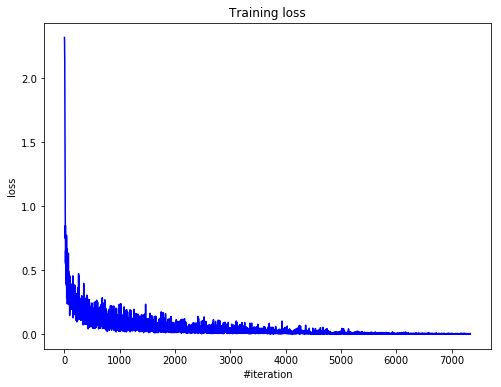

Current loss: 0.001759


In [15]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        default.zeroGradParameters()
        
        # Forward
        predictions = default.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        default.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(default.getParameters(), 
                     default.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [16]:
y_pred = np.argmax(default.forward(X_test), axis=1)
y_real = np.argmax(y_test, axis=1)
accuracy_score(y_real, y_pred)

0.9796103896103896

In [17]:
leaky = Sequential()
leaky.add(Linear(data.shape[1], 100))
leaky.add(LeakyReLU())
leaky.add(Linear(100, y.shape[1]))
leaky.add(SoftMax())

criterion = ClassNLLCriterion()

In [18]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

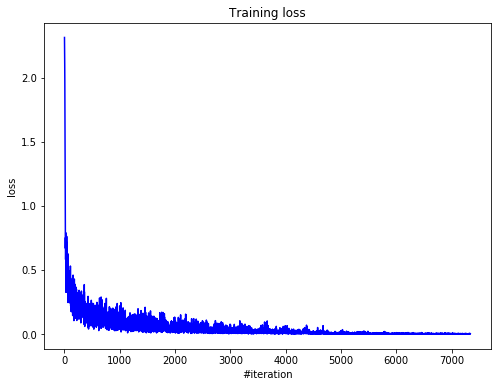

Current loss: 0.002189


In [19]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        leaky.zeroGradParameters()
        
        # Forward
        predictions = leaky.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        leaky.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(leaky.getParameters(), 
                     leaky.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [20]:
y_pred = np.argmax(leaky.forward(X_test), axis=1)
y_real = np.argmax(y_test, axis=1)
accuracy_score(y_real, y_pred)

0.9783549783549783

**Вывод:** Запустив ячейки выше несколько раз я получал, что результаты отличаются незначительно, причем иногда лучше LeakyReLU, а иногда ReLU. Думаю, логично, что точность методов близка: они отличаются идейно не слишком сильно + LeakyReLU был придуман как какое-то улучшение ReLU, но говорят, что это зависит от данных.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [49]:
best = Sequential()
best.add(Linear(data.shape[1], 150))
best.add(LeakyReLU())
best.add(Linear(150, 50))
best.add(LeakyReLU())
best.add(Linear(50, y.shape[1]))
best.add(SoftMax())

criterion = ClassNLLCriterion()

In [50]:
# Optimizer params
optimizer_config = {'learning_rate' : 0.08, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

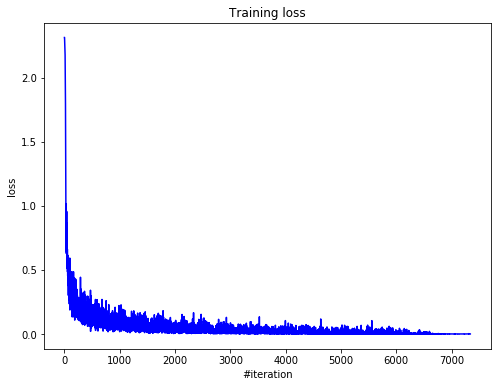

Current loss: 0.000172


In [51]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        best.zeroGradParameters()
        
        # Forward
        predictions = best.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        best.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(best.getParameters(), 
                     best.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

Print here your accuracy. It should be around 90%.

In [52]:
y_pred = np.argmax(best.forward(X_test), axis=1)
y_real = np.argmax(y_test, axis=1)
accuracy_score(y_real, y_pred)

0.9815584415584415

**Вывод:** Постарался сделать получше, чем просто дефолт. Не стал делать Dropout, потому что с ним было только хуже (я так понимаю, потому что данные небольшие, признаков немного - можно не париться со временем, а то, что переобучения нет - видно из score и графиков).